## Step 1: Library import

In [33]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split

from sklearn import svm
from sklearn.model_selection import GridSearchCV

import xray_data #y data: 1 = NORMAL, 0 = PNEUMONIA


## Step: Load and preprocess data
Note: data is resized and preprocessed as read, as a memory optimization.

In [34]:
#Constants
scale = 200
label_filter = ['NORMAL','PNEUMONIA']

In [35]:
X_dev_orig, y_dev_orig = xray_data.load_val(scale,label_filter)
print(f'X_dev_orig, y_dev_orig shape: {X_dev_orig.shape, y_dev_orig.shape}')
print(f'y_dev_orig shape for NORMAL cases: {y_dev_orig[y_dev_orig ==1].shape}')
print('----')

100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (8 of 8) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (8 of 8) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (12 of 12) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


PNEUMONIA: 8
NORMAL: 8
Total: 16
X_dev_orig, y_dev_orig shape: ((16, 40000), (16,))
y_dev_orig shape for NORMAL cases: (8,)
----


In [36]:
# cut of for training samples of each class, only 230 normal rows
test_cutoff = 230

X_test, y_test = xray_data.load_test(scale,label_filter,test_cutoff)
print(f'X_test, y_test shape: {X_test.shape, y_test.shape}')
print(f'y_test shape for NORMAL cases: {y_test[y_test ==1].shape}')
print('----')

100% (106 of 106) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (390 of 390) |######################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (234 of 234) |######################| Elapsed Time: 0:00:04 Time:  0:00:04
100% (41 of 41) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


PNEUMONIA: 115
NORMAL: 115
Total: 230
X_test, y_test shape: ((230, 40000), (230,))
y_test shape for NORMAL cases: (115,)
----


In [37]:
# cut of for training samples of each class, only 1300 normal rows
train_cutoff = 1300

X_train, y_train = xray_data.load_train(scale,label_filter,train_cutoff)

100% (460 of 460) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (3875 of 3875) |####################| Elapsed Time: 0:00:11 Time:  0:00:11
100% (1341 of 1341) |####################| Elapsed Time: 0:00:26 Time:  0:00:26
100% (650 of 650) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


PNEUMONIA: 650
NORMAL: 650
Total: 1300


In [38]:
# I'm not sure what the final stratify parameter is doing.  We'll want to revist when we do full cross validation

X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size = .5, stratify = y_train )
print(f'X_train, y_train shape: {X_train.shape, y_train.shape}')
print(f'y_train shape for NORMAL cases: {y_train[y_train ==1].shape}')
print('----')
print(f'X_dev, y_dev shape: {X_dev.shape, y_dev.shape}')
print(f'y_dev shape for NORMAL cases: {y_dev[y_dev ==1].shape}')

X_train, y_train shape: ((650, 40000), (650,))
y_train shape for NORMAL cases: (325,)
----
X_dev, y_dev shape: ((650, 40000), (650,))
y_dev shape for NORMAL cases: (325,)


## Data Exploration and Interpolation (for more intuitive values)

In [39]:
def interpolate(vector, output_min = 0, output_max = 255):
    interpolated_vector = np.interp(vector, (vector.min(),vector.max()), (output_min, output_max))
    interpolated_vector = interpolated_vector.astype('int64')
    return(interpolated_vector)

In [251]:
X_train

array([[0.38647922, 0.3407098 , 0.31742353, ..., 0.        , 0.        ,
        0.        ],
       [0.01764706, 0.02980392, 0.03137255, ..., 0.0745098 , 0.0745098 ,
        0.42117647],
       [0.17647059, 0.18138824, 0.20933333, ..., 0.04666667, 0.04766275,
        0.04712941],
       ...,
       [0.34510431, 0.35633255, 0.36588235, ..., 0.08666667, 0.09019608,
        0.09019608],
       [0.18031373, 0.19780392, 0.20376471, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.00143951, 0.02500882, ..., 0.        , 0.        ,
        0.        ]])

In [249]:
X_train.shape, X_train[1].shape

((650, 40000), (40000,))

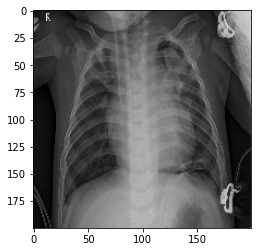

In [250]:
plot_image(X_train[1])

In [44]:
X_train_int = np.array([interpolate(i, output_max = 255) for i in X_train])
X_dev_int = np.array([interpolate(i, output_max = 255) for i in X_dev])

In [46]:
X_dev_int

array([[ 96, 107, 106, ..., 106, 105,  96],
       [ 26,  26,  26, ...,  25,  25,  26],
       [ 41,  50,  56, ...,   0,   0,   0],
       ...,
       [ 33,  35,  36, ...,  15,  17, 104],
       [  6,  10,  17, ...,   0,   0,   0],
       [  1,   5,  18, ..., 200, 207, 207]])

***Check to see that the mean and std are the scaled the same***

In [47]:
X_train_int.mean(), X_train.mean()*255

(123.80004315384615, 122.73745777428708)

In [48]:
X_train_int.std(), X_train.std()*255

(62.37508405012116, 61.544292815512044)

# Gaussian Filters

In [221]:
def plot_image(vector):
    length = vector.shape[0]
    side = np.sqrt(length).astype('int64')
    return(plt.imshow(vector.reshape(side, side), cmap = 'gray'))

In [222]:
kernel1 = np.array([[.1,.1,.1],[.1,.2,.1],[.1,.1,.1]]) #some blur
kernel2 = np.array([[.6,.6,.6],[.6,.1,.6],[.6,.6,.6]]) #lots of blur
kernel3 = np.array([[0,-1,0],[-1,100,-1],[0,-1,0]]) #sharpen

def gauss_filter(data, kernel = np.array([[.1,.1,.1],[.1,.2,.1],[.1,.1,.1]])):
    length = data.shape[0]
    side = np.sqrt(length).astype('int')

    data = data.reshape(side,side)

    new_array = np.zeros((side, side))

    def pad_with(vector, pad_width, iaxis, kwargs):
        pad_value = kwargs.get('padder', 0)
        vector[:pad_width[0]] = pad_value
        vector[-pad_width[1]:] = pad_value

    data = np.pad(data, 1, pad_with)

    i = 0
    while i < side:
        j = 0
        while j < side:
            new_array[i][j] = np.sum(data[i:i+3,j:j+3]* kernel)
            j+=1
        i+=1


    return(new_array.reshape(length))

In [223]:
X_train_blur = np.array([gauss_filter(i, kernel = kernel1) for i in X_train])
X_dev_blur = np.array([gauss_filter(i, kernel = kernel1) for i in X_dev])

In [224]:
X_train_max_blur = np.array([gauss_filter(i, kernel = kernel2) for i in X_train])
X_dev_max_blur = np.array([gauss_filter(i, kernel = kernel2) for i in X_dev])

In [225]:
X_train_sharp = np.array([gauss_filter(i, kernel = kernel3) for i in X_train])
X_dev_sharp = np.array([gauss_filter(i, kernel = kernel3) for i in X_dev])

Text(0.5, 1.0, 'MAX BLUR')

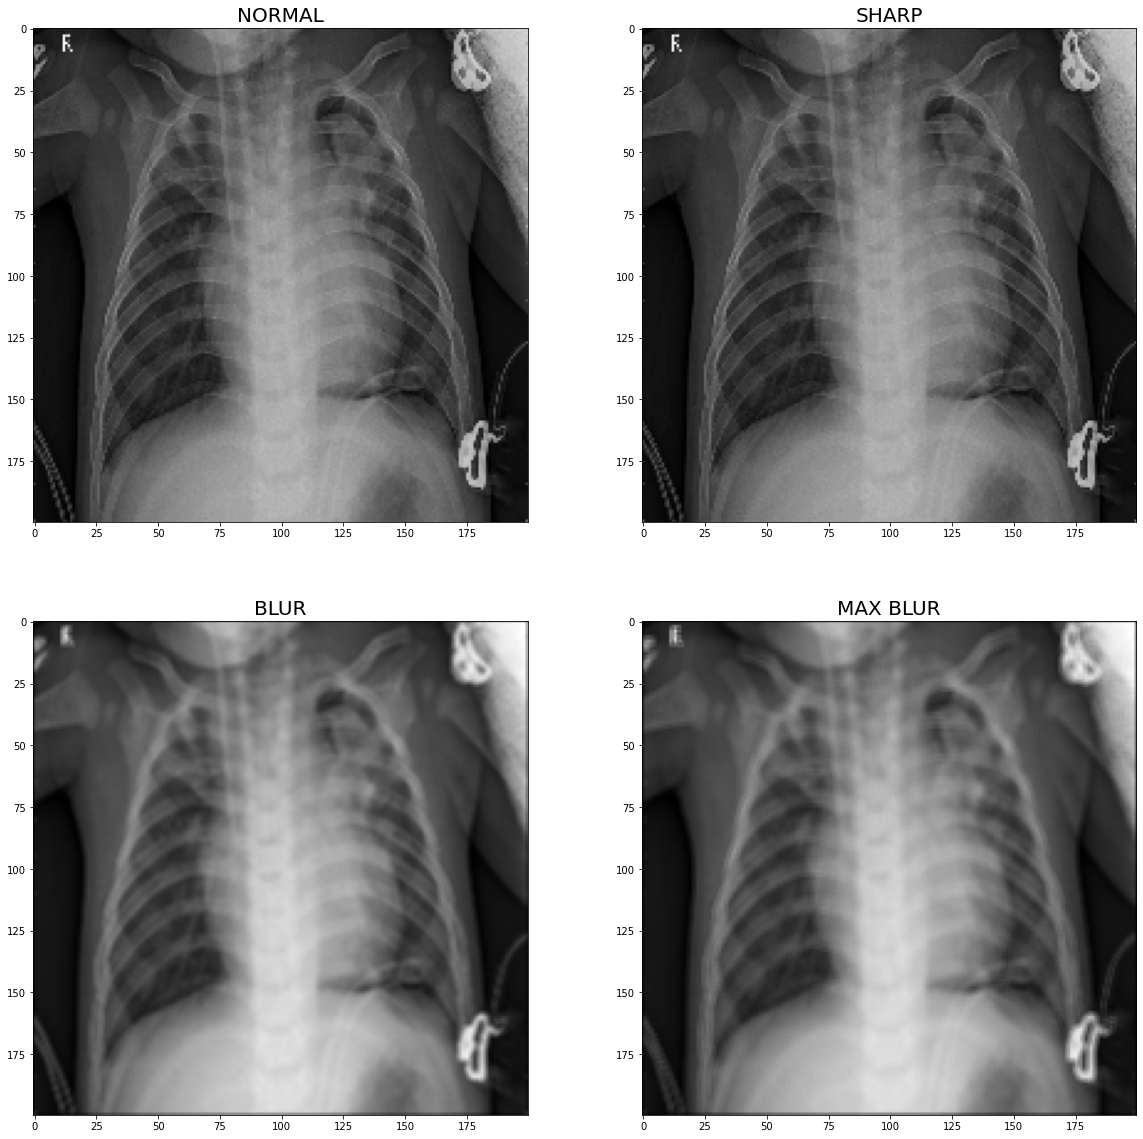

In [242]:
fig, ax = plt.subplots(2,2, figsize = (20,20))
ax[0][0].imshow(X_train[1].reshape(200,200), cmap = 'gray')
ax[0][0].set_title('NORMAL', size = 20)
ax[0][1].imshow(X_train_sharp[1].reshape(200,200), cmap = 'gray')
ax[0][1].set_title('SHARP', size = 20)
ax[1][0].imshow(X_train_blur[1].reshape(200,200), cmap = 'gray')
ax[1][0].set_title('BLUR', size = 20)
ax[1][1].imshow(X_train_max_blur[1].reshape(200,200), cmap = 'gray')
ax[1][1].set_title('MAX BLUR', size = 20)

# Test to See if Sharpening or Blurring Does Anything

In [132]:
NB = MultinomialNB()
NB.fit(X_train, y_train)
NB.score(X_dev, y_dev)


0.8061538461538461

In [133]:
NB2 = MultinomialNB()
NB2.fit(X_train_sharp, y_train)
NB2.score(X_dev_sharp, y_dev)

0.5015384615384615

In [134]:
NB3 = MultinomialNB()
NB3.fit(X_train_filtered, y_train)
NB3.score(X_dev_filtered, y_dev)

0.5076923076923077

##  What do the average lungs look like between Healthy and Sick Patients?

In [157]:
sick = X_train[y_train == 0]
average_sick = sick.mean(axis = 0)

healthy = X_train[y_train == 1]
average_healthy = healthy.mean(axis = 0)


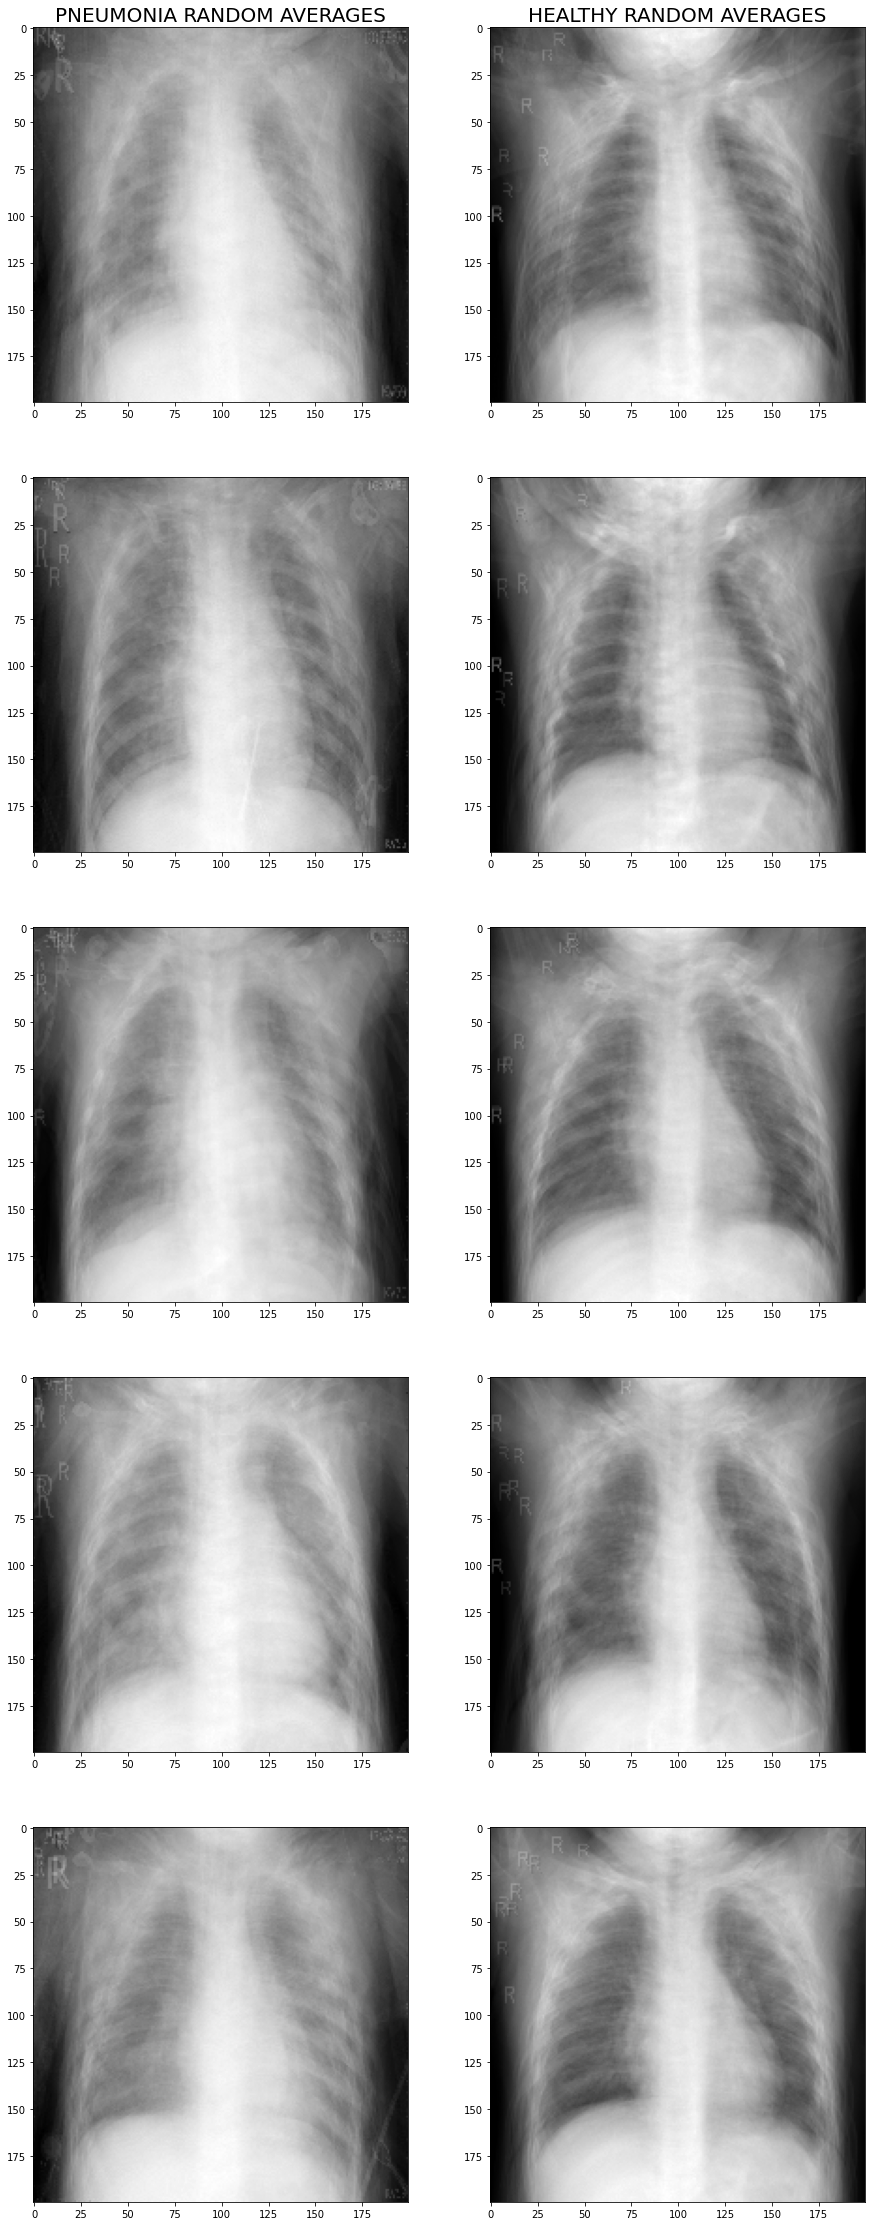

In [244]:
fig, ax = plt.subplots(5,2, figsize = (15,40))
ax[0][0].set_title('PNEUMONIA RANDOM AVERAGES', size = 20)
ax[0][1].set_title('HEALTHY RANDOM AVERAGES', size = 20)
for i in range(5):
    rand_vectors= np.random.choice(325, 10)
    ax[i][0].imshow(sick[rand_vectors].mean(axis =0).reshape(200,200), cmap = 'gray')
    ax[i][1].imshow(healthy[rand_vectors].mean(axis = 0).reshape(200,200), cmap = 'gray')